In [ ]:
#@markdown Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@markdown Imports and settings
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy import interpolate

os.chdir('/content/drive/MyDrive/Neuro/NMA/NMA22_proj')

from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 15]
rcParams['figure.facecolor'] = [1, 1, 1]
rcParams['font.size'] = 15
rcParams['legend.fontsize'] = 10
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@markdown Load data
with open('choice_signal_dat', 'rb') as inf:
  choice_signal_dat = pickle.load(inf)

with open('behav_readout_vals', 'rb') as inf:
  readouts = pickle.load(inf)

with open('barea', 'rb') as inf:
  barea = pickle.load(inf)

# General description
`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  

# Generate region specific firing details, RT aligned

`generate_rtaln_dat_sesh(region_of_interest, l_pad=45, r_pad=20)`<br>
Returns a dictionary with session index (0,..., 38) as keys and list as values, containing-<br>
RT aligned spiking data \[with dims: `(n_occurrence_reg, n_trials, window_len)`\]<br>
contrast_right, contrast_left \[with dims: `(2, n_trials)`\]<br>
response \[with dims: `(n_trials,)`\]<br>
slicing_index \[list of len `n_trials`\]<br>
`dict['region']` should return the region name

In [ ]:
#@markdown Helper functions
def gaussian(x, sigma, mu = 0):
  """Gaussian pdf"""
  return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def calc_auc(region, session_id):
  """
  Returns the AUC vals for (contra-specific firing rate - ipsi-specific firing rate)
  For all the neurons in certain region (region), in a certain session (session_id)
  """
  try:
    reg_dat = choice_signal_dat[region] 
  except:
    raise KeyError('Region not found in the pickle')

  dat = reg_dat[session_id]
  firing = dat[0]
  resp = dat[2]
  neuron = firing.shape[0]
  AUC_vals = []

  for i in range(neuron):
    diff = 100*(firing[i][resp == -1,:].mean(axis = 0)\
          -firing[i][resp == 1,:].mean(axis = 0))
    AUC = metrics.auc(np.array(range(65))/100, diff)
    AUC_vals.append(AUC)

  return np.array(AUC_vals)

def plot_AUC_hist(region, session_id, ax, bins = 30, density = True):
  """Plots the AUC val histogram"""
  AUC_val = calc_auc(region, session_id)
  ax.hist(AUC_val, bins = 30, density = density, color = 'b', alpha = 0.5)
  ax.set_xlabel('Firing rate (Hz)')
  ax.set_title('region '+str(session_id))

def find_confidence_interval_bounds(auc_val, print_param = True, bins = 30):
  """
  For a given AUC distribution, calculated the 99% confidence interval boundaries
  """
  distrib = np.histogram(auc_val, density = True, bins = bins)
  count = distrib[0]
  points = [(distrib[1][j]+distrib[1][j+1])/2 for j in range(distrib[1].shape[0]-1)]

  popt, _ = curve_fit(gaussian, points, count, bounds = (0, 200))

  # okay, mind these values
  # we don't allow the 95% conf interval to go beyond 200 Hz
  # and the mean should be 0 +- 3
  if popt[0] > 200 or abs(popt[1]) > 3:
    raise ValueError('Sus confidence interval found: recheck')
  
  if print_param:
    print(f"Sigma: {popt[0]:.4f}, mu: {popt[1]:.4f}")

  return 2*popt[0]

def plot_violin(region, ax):
  """Plots the violin plot all the sessions, for a certain region"""
  try:
    reg_dat = choice_signal_dat[region]
  except:
    raise KeyError('Region not found in the pickle')   

  sessions = list(reg_dat.keys())[:-1]
  x_vals = []; aucs = np.array([])
  for sesh in sessions:
    auc_vals = calc_auc(region, sesh)
    aucs = np.hstack((aucs, auc_vals))
    x_vals += [sesh]*auc_vals.shape[0]

  sns.violinplot(x = x_vals, y = aucs, ax = ax)
  ax.set_ylabel('Diff bw contra & ipsi rates');
  ax.set_xlabel('Session ID')
  ax.set_title(region);

def average_smoothener(array):
  """
  Default bin width is 3
  """
  n = array.shape[0]
  new_array = []
  for i in range(1, n-2):
    new_array.append(array[i-1:i+2].mean())
  return np.array(new_array)

def deblobbify(x_val, y_val, bin_len = 0.1):
  x_n = np.arange(x_val.min(), x_val.max(), bin_len)
  x_n_mid = [(x_n[i]+x_n[i+1])/2 for i in range(len(x_n)-1)]
  y_n = np.array(y_val[x_val<bin_len].mean())
  for i in range(1, len(x_n)-1):
    ind = np.logical_and(x_val>=x_n[i],x_val<x_n[i+1])
    to_add = y_val[ind]
    if to_add.shape[0] == 0:
      to_add = 100
    else:
      to_add = to_add.mean()
    y_n = np.hstack((y_n, to_add))

  return np.array(x_n_mid)[y_n != 100], y_n[y_n != 100]

In [ ]:
#@markdown Regions included in `choice_signal_dat`
choice_signal_dat.keys()

dict_keys(['ZI', 'MRN', 'SCm', 'SNr', 'SSp', 'MOp', 'MOs'])

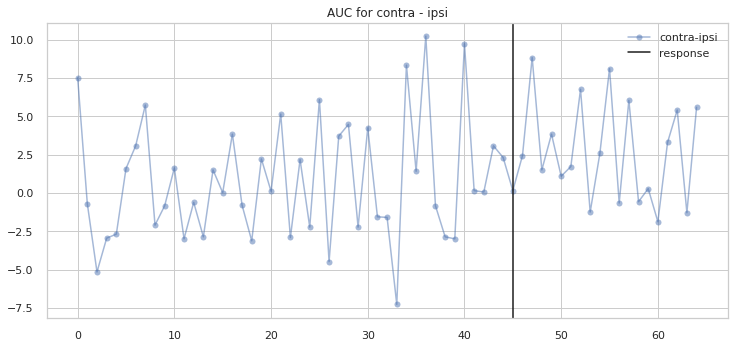

In [ ]:
#@title (contra_resp - ipsi_resp) difference plot
#@markdown Region: ZI, session: 14, neuron (i): 36

zi_dat = choice_signal_dat['ZI']
dat = zi_dat[14]
firing = dat[0]; n = firing.shape[0]
resp = dat[2]
ax = plt.subplot(1,2,1)

i = 36

ax.plot(100*(firing[i][resp == -1,:].mean(axis = 0)
        -firing[i][resp == 1,:].mean(axis = 0)), 
        'bo-', alpha = 0.5)
ax.axvline(45, 0, 3, color = 'k')


ax.legend(['contra-ipsi', 'response']);
ax.set_title('AUC for contra - ipsi')
plt.grid(True)

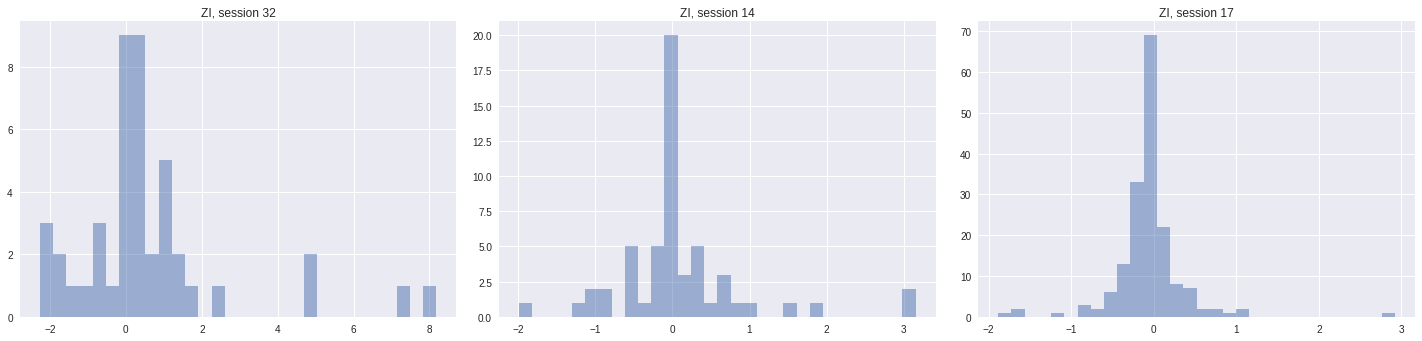

In [ ]:
auc_vals0 = calc_auc('ZI', 32)
auc_vals1 = calc_auc('ZI', 14)
auc_vals2 = calc_auc('ZI', 17)

ax0 = plt.subplot(1,3,1)
ax0.hist(auc_vals0, bins = 30, alpha = 0.5);
ax0.set_title('ZI, session '+str(32));
plt.grid(True)

ax1 = plt.subplot(1,3,2)
ax1.hist(auc_vals1, bins = 30, alpha = 0.5);
ax1.set_title('ZI, session '+str(14));
plt.grid(True)

ax2 = plt.subplot(1,3,3)
ax2.hist(auc_vals2, bins = 30, alpha = 0.5);
ax2.set_title('ZI, session '+str(17));
plt.grid(True)

sigma = 0.298, mu = 0.000


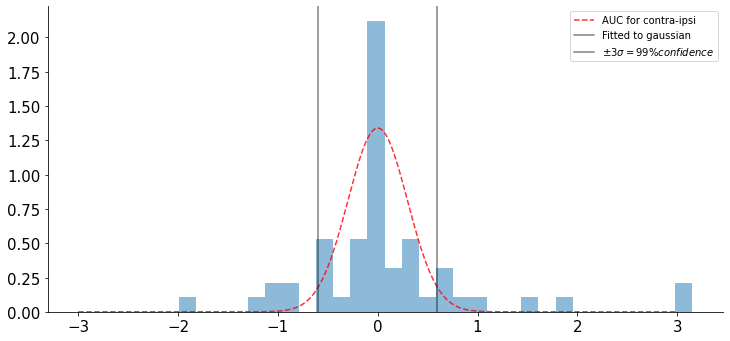

In [ ]:
auc_vals1 = calc_auc('ZI', 14)
distrib = np.histogram(auc_vals1, density = True, bins = 30)
count = distrib[0]
points = [(distrib[1][j]+distrib[1][j+1])/2 for j in range(distrib[1].shape[0]-1)]

popt, pcov = curve_fit(gaussian, points, count, bounds = (0, 10))
xdat = np.linspace(-3, 3, 500)
print(f"sigma = {popt[0]:.3f}, mu = {popt[1]:.3f}")
plt.subplot(1,2,1)
plt.hist(auc_vals1, bins = 30, density = True, 
         histtype = 'stepfilled', alpha = 0.5);
plt.plot(xdat, gaussian(xdat, *popt), 'r--', alpha = 0.8);
plt.axvline(2*popt[0], 0, 1, color = 'k', alpha = 0.5)
plt.axvline(-2*popt[0], 0, 1, color = 'k', alpha = 0.5)
plt.legend(["AUC for contra-ipsi", "Fitted to gaussian", "$\pm 3\sigma = 99\% confidence$"]);

In [ ]:
auc_val = calc_auc('ZI', 14)
auc_val_man = auc_val[np.logical_and(auc_val > -150, auc_val < 150)]
ci = find_confidence_interval_bounds(auc_val)
ci_man = find_confidence_interval_bounds(auc_val_man)

# just trying out the percentiles
auc_val = auc_val[auc_val.argsort()]
print(f"5 %ile: {np.percentile(auc_val,5):.4f}, Median: {np.percentile(auc_val,50):.4f}, 95 %ile: {np.percentile(auc_val,95):.4f}")
print(f"25 %ile: {np.percentile(auc_val,25):.4f}, Median: {np.percentile(auc_val,50):.4f}, 75 %ile: {np.percentile(auc_val,75):.4f}")

Sigma: 29.7753, mu: 0.0000
Sigma: 25.2161, mu: 0.0000
5 %ile: -104.1622, Median: -0.8732, 95 %ile: 158.4961
25 %ile: -18.1284, Median: -0.8732, 75 %ile: 25.6769


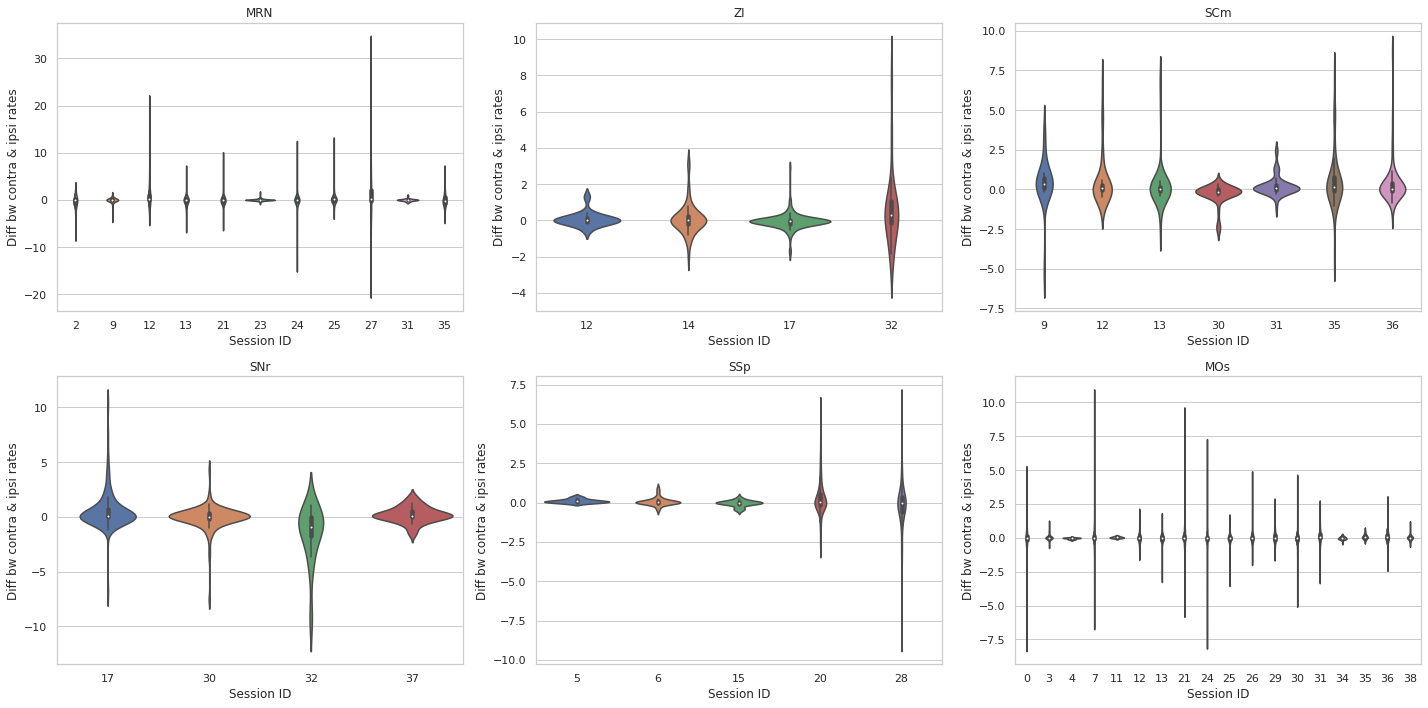

In [ ]:
sns.set_theme(style = 'whitegrid')
plt.rcParams['figure.figsize'] = (20, 10)

reg = ['MRN', 'ZI', 'SCm', 'SNr', 'SSp', 'MOs']
fig, axs = plt.subplots(2, 3)

for i in range(2):
  for j in range(3):
    plot_violin(reg[3*i+j], axs[i,j])

Text(0.5, 1.0, 'Acceleration for contra in 32')

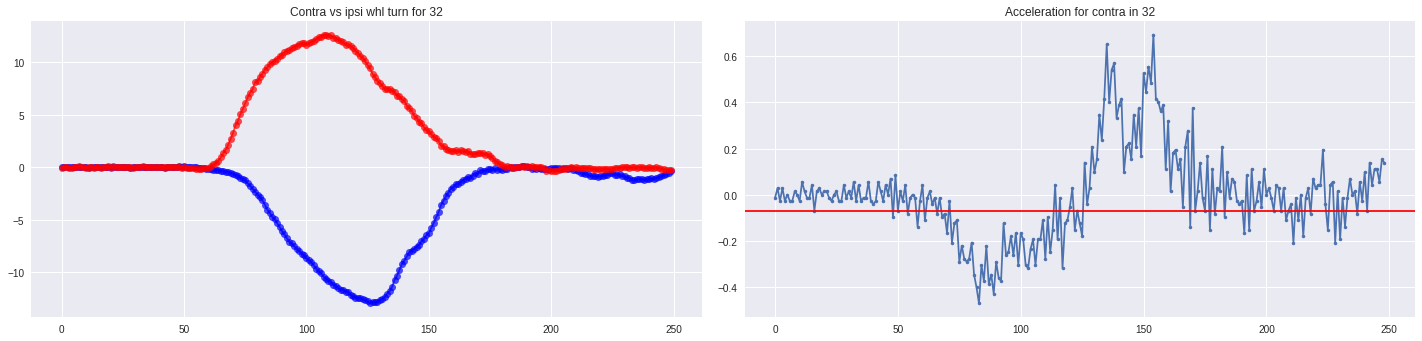

In [ ]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (20, 5)


whl_spd = readouts['whl_spd']
gc = readouts['gc']
rt = readouts['rt']
sesh = 32
zi_dat = choice_signal_dat['ZI']
index = zi_dat[sesh][-1]; resp = zi_dat[sesh][2]
whl = whl_spd[sesh].reshape(-1,250)[index,:]
gc = gc[sesh]
rt = rt[sesh]
whl_rt = whl[resp == -1].mean(0); whl_lf = whl[resp == 1].mean(0)

plt.subplot(1,2,1)
plt.plot(whl_rt, 'bo-', alpha = 0.7)
plt.plot(whl_lf, 'ro-', alpha = 0.7)
plt.title('Contra vs ipsi whl turn for '+str(sesh))
plt.grid(True)


whl_acc = np.diff(whl_rt) #turn^2/time_bin_10ms
thresh1 = whl_acc[:20].min()

plt.subplot(1,2,2)
plt.plot(whl_acc, '.-'); plt.grid(True)
plt.axhline(thresh1, 0, 250, color = 'r')
plt.title('Acceleration for contra in '+str(sesh))

(0.0, 200.0)

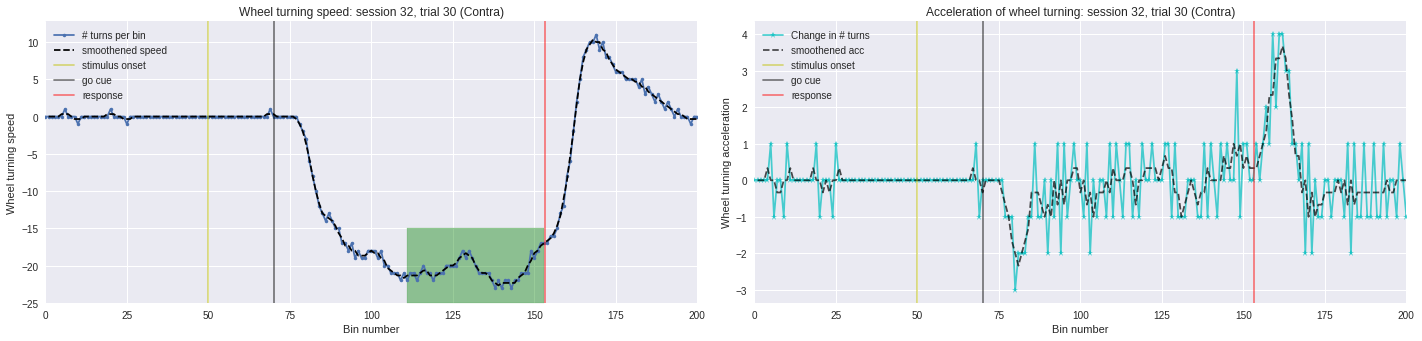

In [ ]:
# trial specific plot
i = 30
plt.subplot(1,2,1)
plt.plot(whl[i], '.-')
plt.plot(range(1, 248), average_smoothener(whl[i]), 'k--')
plt.axvline(50, -15, 2, color = 'y', alpha = 0.5)
plt.axvline(100*gc[i], -15, 2, color = 'k', alpha = 0.5)
plt.axvline(100*rt[i], -15, 2, color = 'r', alpha = 0.5)

a = np.linspace(111, 153, 5)
b = -25*np.ones_like(a); c = -15*np.ones_like(a)
plt.fill_between(a, b, c,
                 color = 'g', alpha = 0.4)


plt.legend(["# turns per bin", "smoothened speed", "stimulus onset", "go cue", "response"])
plt.title("Wheel turning speed: session 32, trial 30 (Contra)")
plt.xlabel("Bin number"); plt.ylabel("Wheel turning speed")
plt.xlim((0, 200))
plt.ylim(bottom = -25)

plt.subplot(1,2,2)
plt.plot(np.diff(whl[i]), 'c*-', alpha = 0.7)
blah = average_smoothener(np.diff(whl[i]))
plt.plot(range(1, 247), blah, 'k--', alpha = 0.7)
plt.axvline(50, -15, 2, color = 'y', alpha = 0.5)
plt.axvline(100*gc[i], -15, 2, color = 'k', alpha = 0.5)
plt.axvline(100*rt[i], -15, 2, color = 'r', alpha = 0.5)
plt.legend(["Change in # turns", "smoothened acc", "stimulus onset", "go cue", "response"])
plt.title("Acceleration of wheel turning: session 32, trial 30 (Contra)")
plt.xlabel("Bin number"); plt.ylabel("Wheel turning acceleration")
plt.xlim((0, 200))

# Some proper analysis stuff :)

In [ ]:
def determine_confidence_estimator(sesh_id, trial, behav_readouts = readouts):
  """
  Returns the confidence readout estimates
  i.e. mean speed over a certain time window, peak acceleration before response and 1/response_time
  """
  whl_spd = behav_readouts['whl_spd'][sesh_id].reshape(-1,250)[trial]
  #whl_spd = average_smoothener(whl_spd)
  whl_acc = np.diff(whl_spd)
  whl_acc = average_smoothener(whl_acc)
  gc = int(100*behav_readouts['gc'][sesh_id][trial])
  rt = int(100*behav_readouts['rt'][sesh_id][trial])
  rsp = behav_readouts['resp_dir'][sesh_id][trial]

  speed = whl_spd[gc + (rt - gc)//2: rt].mean()

  #plt.subplot(1,2,1); plt.plot(whl_spd); plt.plot(np.abs(whl_acc), 'k--'); plt.axvline(gc, -20, 10); plt.axvline(rt, -20, 10); plt.axvline(gc + (rt - gc)//2, -20, 10, color = 'r'); plt.xlim((0,rt+50))

  acc_val = max(np.abs(whl_acc[50:rt]))
  """
  abs_acc_postGC = np.abs(whl_acc)[gc:]
  thresh_cross = gc + np.where(np.logical_and(abs_acc_postGC>thresh-.001,
                                         abs_acc_postGC<thresh+.001)==True)[0]
  acc_dir = np.sign(np.abs(whl_acc))[thresh_cross]
  print(thresh_cross, acc_dir)
  time_index = 1 + thresh_cross[0]


  if time_index<rt and time_index>gc:
    speed = whl_spd[time_index:rt].mean()
    print(time_index, rt); plt.axvline(time_index, -20, 10, color = 'r')
  else:"""

  return speed, rsp*acc_val, 100/rt 

determine_confidence_estimator(32, 28)

(10.428571428571429, 2.3333333333333335, 1.5384615384615385)

In [ ]:
def find_choice_neurons(region, sesh):
  """
  Returns the indices of possibly choice-encoding neurons
  """
  dat = choice_signal_dat[region][sesh]
  auc_val = calc_auc(region, sesh)
  thresh = find_confidence_interval_bounds(auc_val, print_param = False)
  return np.arange(0, auc_val.shape[0], 1)[auc_val >= thresh]

find_choice_neurons('ZI', 17)

array([ 10,  11,  15,  50,  63,  71,  96,  98, 119, 130, 134, 146, 154])

In [ ]:
# functions needed for the code block below
def line(x, a, b):
  return a*x + b

def corr(arr1, arr2):
  a1 = arr1 - arr1.mean()
  a2 = arr2 - arr2.mean()
  return np.sum(a1*a2)/(np.sum(a1**2)*np.sum(a2**2))**.5

def basic_processing(a_inp, c_inp):
  a_n = np.unique(a_inp); s_n = np.array([])
  for i in a_n:
    s_n = np.hstack((s_n, c_inp[a_inp == i].mean()))
  return a_n, s_n


{'spd': [-0.11363615702457028, -0.033902038863608444], 'acc': [-0.06292838961085036, 0.06925332460476463], 'rt': [-0.09472255053856925, -0.01947448326544299]}


Text(0.001, 0.3, 'Confidence readouts')

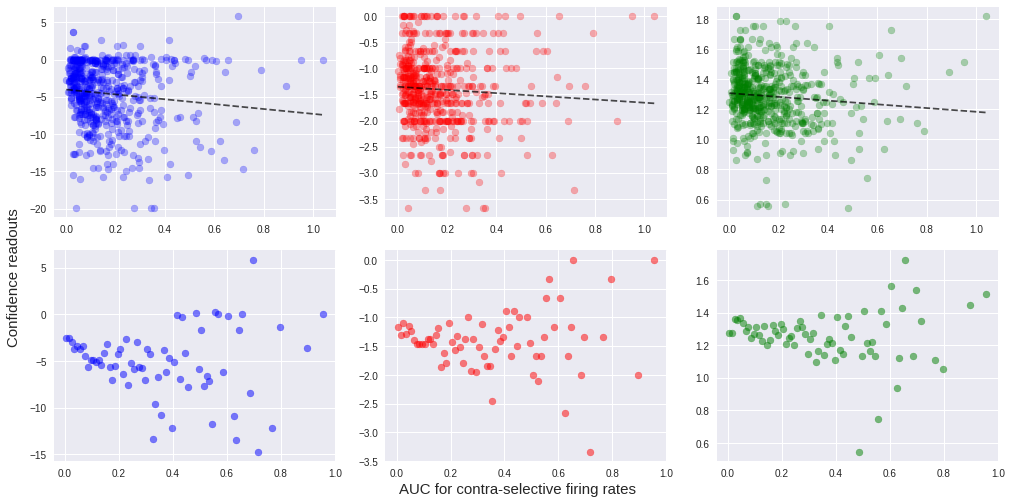

In [ ]:
def choice_signal_matrix_per_session(session_id, plot = True, custom_reg = [False]):
  if custom_reg[0] == True:
    reg_needed = custom_reg[1:]
  all_choice_area = np.array(['ZI', 'MRN', 'SCm', 'SNr', 'SSp', 'MOp', 'MOs'])
  reg_in_sesh = np.unique(barea[session_id])
  reg_needed = np.intersect1d(all_choice_area, reg_in_sesh)
  if len(reg_needed) == 0:
    return 0

  auc_val = np.array([])
  spd = np.array([])
  acc = np.array([])
  rt = np.array([])

  for area in reg_needed: 
    area_neurons = find_choice_neurons(area, session_id)
    area_dat = choice_signal_dat[area][session_id]

    trials = np.arange(len(area_dat[3]))[area_dat[3]]
    resp = area_dat[2]
    # focusing only on the contralateral response cases
    trials = trials[resp == -1]
    firing = area_dat[0][:,resp == -1]

    for neuron in area_neurons:
      for i, t in enumerate(trials):
        confid = determine_confidence_estimator(session_id, t)
        auc_val = np.hstack((auc_val, 
                             metrics.auc(np.arange(65)/100, firing[neuron, i])))
        spd = np.hstack((spd, confid[0]))
        acc = np.hstack((acc, confid[1]))
        rt = np.hstack((rt, confid[2]))

  corr_vals = {}
  # for speed
  auc, spd = basic_processing(auc_val, spd)
  auc_n, spd_n = deblobbify(auc, spd, 0.01)
  corr_vals['spd'] = [corr(auc, spd), corr(auc_n, spd_n)]

  # for acceleration
  auc, acc = basic_processing(auc_val, acc)
  auc_n, acc_n = deblobbify(auc, acc, 0.01)
  corr_vals['acc'] = [corr(auc, acc), corr(auc_n, acc_n)]

  # for rt
  auc, rt = basic_processing(auc_val, rt)
  auc_n, rt_n = deblobbify(auc, rt, 0.01)
  corr_vals['rt'] = [corr(auc, rt), corr(auc_n, rt_n)]

  # plots
  x = np.linspace(0, auc_val.max(), 50)
  if plot:
    # speed
    plt.subplot(2,3,1)
    plt.scatter(auc, spd, alpha = 0.3, color = 'b')
    popt, _ = curve_fit(line, auc, spd)
    plt.plot(x, line(x, popt[0], popt[1]), 'k--', alpha = 0.7)

    # acc
    plt.subplot(2,3,2)
    plt.scatter(auc, acc, alpha = 0.3, color = 'r')
    popt, _ = curve_fit(line, auc, acc)
    plt.plot(x, line(x, popt[0], popt[1]), 'k--', alpha = 0.7)

    # rt
    plt.subplot(2,3,3)
    plt.scatter(auc, rt, alpha = 0.3, color = 'g')
    popt, _ = curve_fit(line, auc, rt)
    plt.plot(x, line(x, popt[0], popt[1]), 'k--', alpha = 0.7)

    plt.subplot(2,3,4)
    plt.scatter(auc_n, spd_n, color = 'b', alpha = 0.5)

    plt.subplot(2,3,5)
    plt.scatter(auc_n, acc_n, color = 'r', alpha = 0.5)

    plt.subplot(2,3,6)
    plt.scatter(auc_n, rt_n, color = 'g', alpha = 0.5)

    title = "Session "+str(session_id)+" for "+','.join(list(reg_needed))

  return corr_vals


fig = plt.gcf()
fig.set_size_inches(14, 7)
plt.style.use("seaborn")
dic= choice_signal_matrix_per_session(17)
print(dic)

fig.text(0.5, 0.001, 'AUC for contra-selective firing rates', ha='center')
fig.text(0.001, 0.3, 'Confidence readouts', ha='center', rotation = 'vertical')


In [ ]:
spd_corr1 = []; spd_corr2 = []
acc_corr1 = []; acc_corr2 = []
rt_corr1 = []; rt_corr2 = []
for i in range(39):
  try:
    dic = choice_signal_matrix_per_session(i, plot = False)
    if dic == 0:
      continue
    if dic['acc'][1] <-.5:
      print(i)
    spd_corr1.append(dic['spd'][0]); spd_corr2.append(dic['spd'][1])
    acc_corr1.append(dic['acc'][0]); acc_corr2.append(dic['acc'][1])
    rt_corr1.append(dic['rt'][0]); rt_corr2.append(dic['rt'][1])
  except:
    continue

7
10
27
28
29
32


In [ ]:
all_choice_area = np.array(['ZI', 'MRN', 'SCm', 'SNr', 'SSp', 'MOp', 'MOs'])
for session_id in [5,7,10,11,28,29,30,32]:
  reg_in_sesh = np.unique(barea[session_id])
  reg_needed = np.intersect1d(all_choice_area, reg_in_sesh)
  print(reg_needed)

['SSp']
['MOs']
['MOp']
['MOs']
['MOp' 'SSp']
['MOs']
['MOs' 'SCm' 'SNr']
['SNr' 'ZI']


Text(0, 0.5, 'Correlation coefficient')

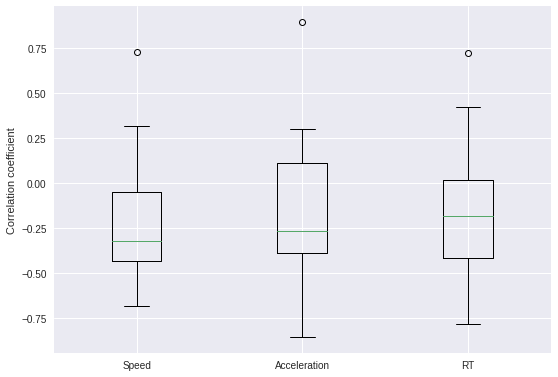

In [ ]:
plt.boxplot([spd_corr2, acc_corr2, rt_corr2]);
plt.xticks([1,2,3], ["Speed", "Acceleration", "RT"]);
plt.ylabel("Correlation coefficient")

87 87


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


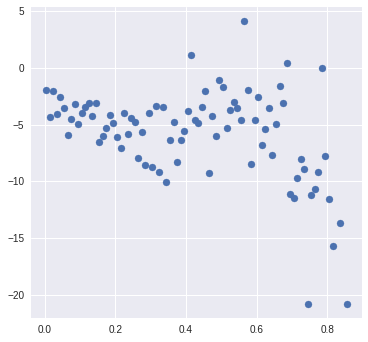

In [ ]:
#@markdown Dump
# Take two regions: ZI and SNr
# Consider sesssion 17
rcParams['figure.figsize'] = (15, 5)
def line(x, a, b):
  return a*x + b
sesh = 12
zi_neurons = find_choice_neurons('MRN', sesh)
zi_dat = choice_signal_dat['MRN'][sesh]

zi_trials = np.arange(len(zi_dat[3]))[zi_dat[3]]
zi_resp = zi_dat[2]
zi_trials = zi_trials[zi_resp == -1]
zi_firing = zi_dat[0][:,zi_resp == -1]

snr_neurons = find_choice_neurons('SCm', sesh)
snr_dat = choice_signal_dat['SCm'][sesh]

snr_trials = np.arange(len(snr_dat[3]))[snr_dat[3]]
snr_resp = snr_dat[2]
snr_trials = snr_trials[snr_resp == -1]
snr_firing = snr_dat[0][:,snr_resp == -1]


auc_val = []
spd = []
acc = []
rt = []

for neuron in zi_neurons:
  for i, t in enumerate(zi_trials):
    confid = determine_confidence_estimator(sesh, t)
    auc_val.append(metrics.auc(np.arange(65)/100, zi_firing[neuron, i]))
    spd.append(confid[0])
    acc.append(confid[1])
    rt.append(confid[2])


for neuron in snr_neurons:
  for i, t in enumerate(snr_trials):
    confid = determine_confidence_estimator(sesh, t)
    auc_val.append(metrics.auc(np.arange(65)/100, snr_firing[neuron, i]))
    spd.append(confid[0])
    acc.append(confid[1])
    rt.append(confid[2])

auc_val = np.array(auc_val)
spd = np.array(spd)
plt.subplot(1,3,1)
auc_n, spd_n = deblobbify(auc_val, spd, .01)
print(len(auc_n), len(spd_n))

plt.scatter(auc_n, spd_n)

Spd to AUC correlation after 'deblobbifying':  -0.15147001302517174
Spd to AUC correlation after 'deblobbifying':  -0.20636059918643448


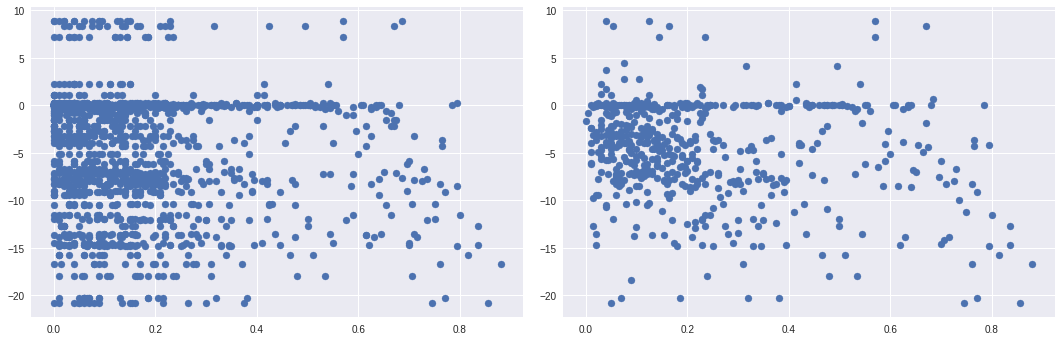

In [ ]:
#@markdown Dump, again
plt.subplot(1,2,1)
plt.scatter(auc_val, spd)
x_v = auc_val - auc_val.mean(); y_v = spd - spd.mean()
print("Spd to AUC correlation after \'deblobbifying\': ", np.sum(x_v*y_v)/(np.sum(x_v**2)*np.sum(y_v**2))**.5)

plt.subplot(1,2,2)
a_n = np.unique(auc_val); s_n = np.array([])
for i in a_n:
  s_n = np.hstack((s_n, spd[auc_val == i].mean()))

plt.scatter(a_n, s_n)
x_v = a_n - a_n.mean(); y_v = s_n - s_n.mean()
print("Spd to AUC correlation after \'deblobbifying\': ", np.sum(x_v*y_v)/(np.sum(x_v**2)*np.sum(y_v**2))**.5)

In [ ]:
def make_input_matrix(session_id):
  all_choice_area = np.array(['ZI', 'MRN', 'SCm', 'SNr', 'SSp', 'MOp', 'MOs'])
  reg_in_sesh = np.unique(barea[session_id])
  reg_needed = np.intersect1d(all_choice_area, reg_in_sesh)

  auc_val = np.array([])
  for area in reg_needed: 
    area_neurons = find_choice_neurons(area, session_id)
    area_dat = choice_signal_dat[area][session_id]

    trials = np.arange(len(area_dat[3]))[area_dat[3]]
    resp = area_dat[2]
    # focusing only on the contralateral response cases
    trials = trials[resp == -1]; N = len(trials)
    firing = area_dat[0][:,resp == -1]

    for neuron in area_neurons:
      for i in range(N):
        auc_val = np.hstack((auc_val, 
                             metrics.auc(np.arange(65)/100, firing[neuron, i])))
  
  return trials, np.c_[np.ones(N), auc_val.reshape(N, -1)]

_, X = make_input_matrix(12)
X.shape

(91, 30)

In [ ]:
def fit_linear_mod(y, X):
  return np.linalg.inv(X.T @ X) @ (X.T @ y)

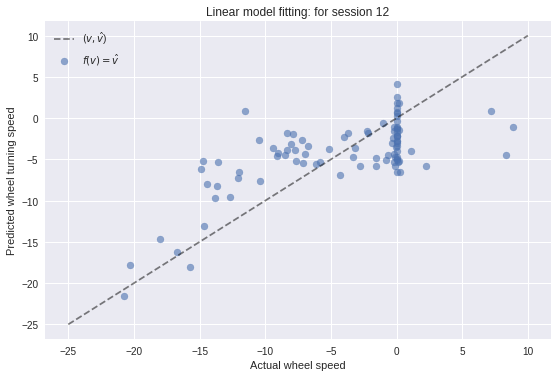

In [ ]:
sesh = 12
whl_spd = readouts['whl_spd'][12].reshape(-1,250)
t, X = make_input_matrix(sesh)
spd = np.array([])
for i in t:
  conf = determine_confidence_estimator(sesh, i)
  spd = np.hstack((spd, conf[0]))

theta = fit_linear_mod(spd, X)
spd_hat = X @ theta
plt.scatter(spd, spd_hat, alpha = 0.6)
plt.plot(np.linspace(-25, 10, 10), np.linspace(-25, 10, 10), 'k--', alpha = 0.5)
plt.xlabel("Actual wheel speed"); plt.ylabel("Predicted wheel turning speed")
plt.title("Linear model fitting: for session "+str(sesh))
plt.legend(['$(v,\hat{v}$)', '$f(v) = \hat{v}$'])

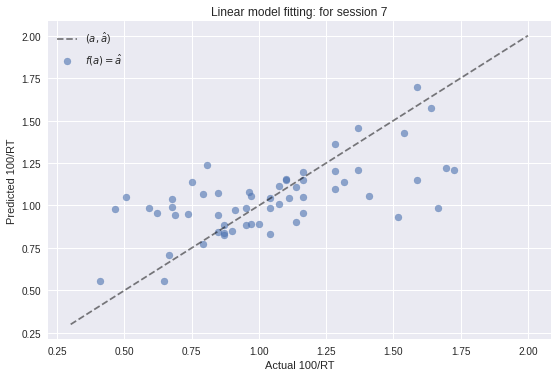

In [ ]:
sesh = 7
t, X = make_input_matrix(sesh)
spd = np.array([])
for i in t:
  conf = determine_confidence_estimator(sesh, i)
  spd = np.hstack((spd, conf[2]))

theta = fit_linear_mod(spd, X)
spd_hat = X @ theta
plt.scatter(spd, spd_hat, alpha = 0.6)
plt.plot(np.linspace(0.3,2,2), np.linspace(0.3,2,2), 'k--', alpha = 0.5)
plt.xlabel("Actual 100/RT"); plt.ylabel("Predicted 100/RT")
plt.title("Linear model fitting: for session "+str(sesh))
plt.legend(['$(a,\hat{a}$)', '$f(a) = \hat{a}$'])

(array([ 2.,  4., 11., 11., 23., 33., 15.,  6.,  5.,  3.]),
 array([-0.62206868, -0.49886489, -0.3756611 , -0.25245731, -0.12925352,
        -0.00604973,  0.11715407,  0.24035786,  0.36356165,  0.48676544,
         0.60996923]),
 <a list of 10 Patch objects>)

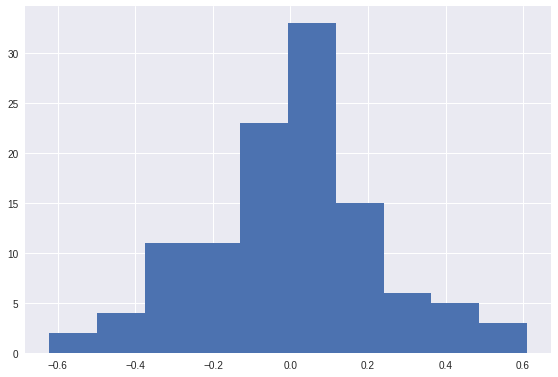

In [ ]:
res = spd-spd_hat
plt.hist(res)